In [1]:
import utilities as ut
import pandas as pd
from utilities import ClusterPlot
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import pyPLS
warnings.simplefilter(action='ignore')

In [2]:
cp_feat_path = "/media/data1/broad_data/cpjump1/2020_11_04_CPJUMP1_all_normalized_feature_select_outlier_trimmed_negcon.csv"
feat_path = cp_feat_path
cell_line = 'A549'
comp_time = 48
pn_cond_query = f"Metadata_experiment_type == 'Compound' \
            & Metadata_cell_line == '{cell_line}' \
            & Metadata_timepoint == {comp_time} \
            & Metadata_experiment_condition == 'Standard' \
            & (Metadata_control_type == 'negcon' \
            | Metadata_control_type == 'poscon_orf') "
# Compound only positive and negative controls DataFrame
comp_opn_df = ut.load_df(feat_path, pn_cond_query)

In [3]:
# Log transform features for improved performance
def log_transform(s):
    if s >= 0:
        return np.log(s + 1)
    if s < 0:
        return -np.log(abs(s) + 1)

comp_opn_df = pd.concat([ut.get_metadata(comp_opn_df), ut.get_featuredata(comp_opn_df).applymap(log_transform)], axis=1)
### Shuffling data to check for overfitting or similar effects.
# comp_opn_df = pd.concat(ut.get_metadata(comp_opn_df).reset_index(drop=True), ut.get_featuredata(comp_opn_df).applymap(log_transform).sample(frac=1).reset_index(drop=True)], axis=1)

In [11]:
# 10 Components shown to give the best results
ncps=4
opn_comp_eq_results, opn_ess_df = ut.calc_eq_score_df_with_cv(fit_df=comp_opn_df, pred_df=comp_opn_df, ncp=ncps)

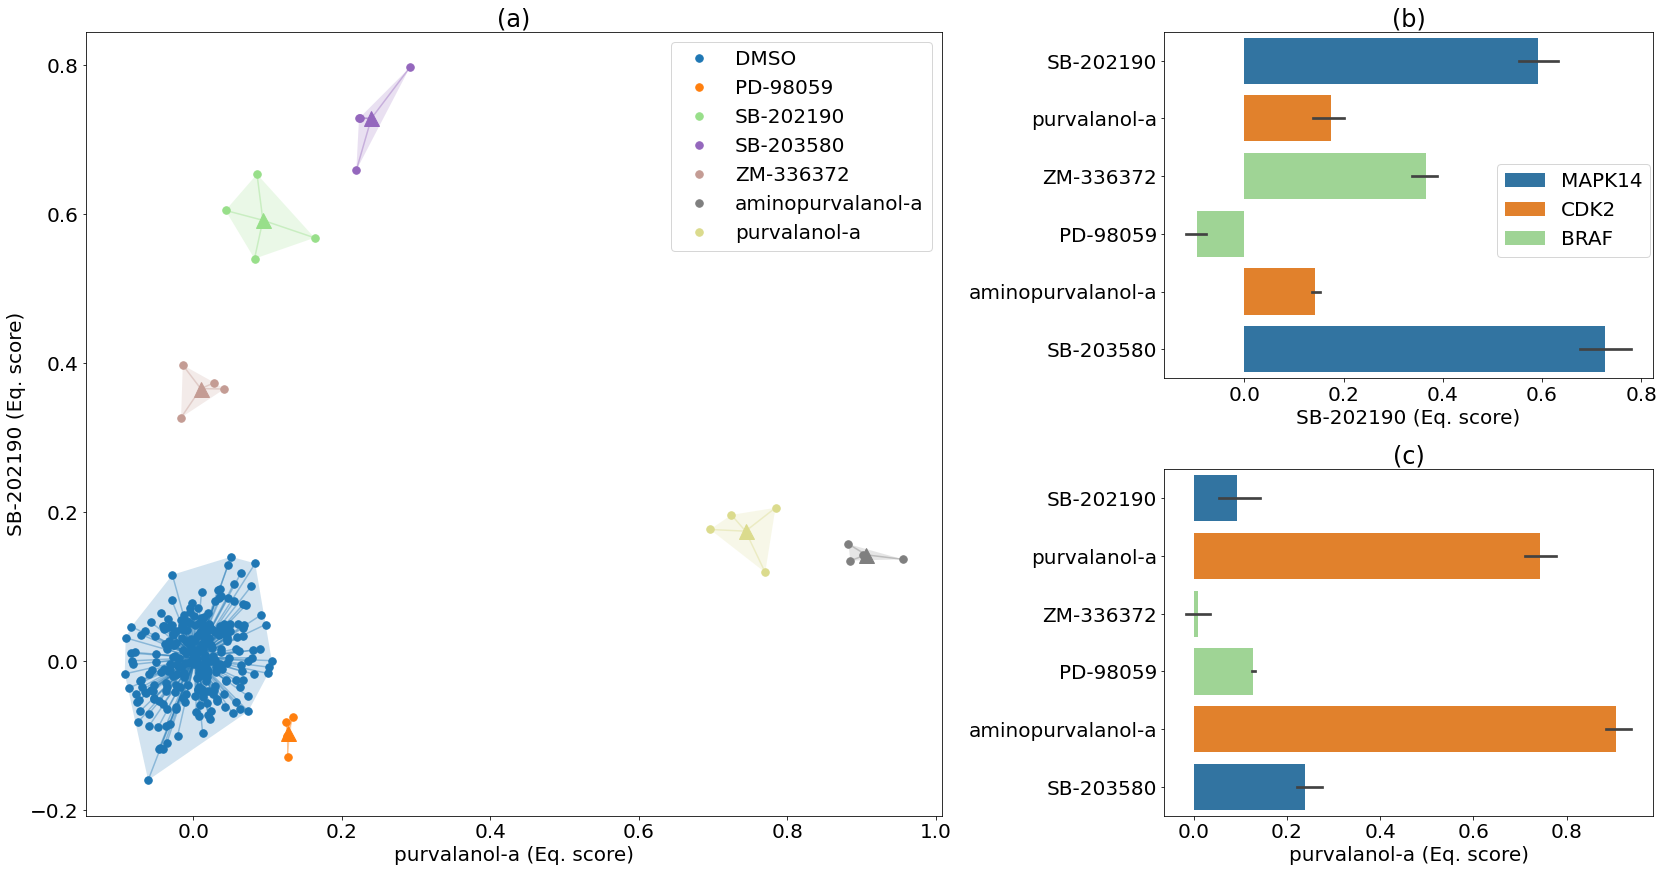

In [12]:
### Generate Figure 4
cp = ClusterPlot()
gs_kw = dict(width_ratios=[1.75, 1], height_ratios=[1, 1])
fig, axd = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(23, 12), layout="constrained", gridspec_kw=gs_kw)
for i, k in enumerate(axd):
    if i == 0:
        cp.plot_fig_with_clusters(opn_comp_eq_results, 'Metadata_pert_iname', x_axis='purvalanol-a_eq', y_axis='SB-202190_eq', ax=axd[k])
        axd[k].set_ylabel('SB-202190 (Eq. score)')
        axd[k].set_xlabel('purvalanol-a (Eq. score)')
        axd[k].legend()
        axd[k].set_title('(a)')
    elif i == 1:
        sns.barplot(x="SB-202190_eq", y="Metadata_pert_iname", data=opn_comp_eq_results[opn_comp_eq_results['Metadata_pert_iname'] != 'DMSO'], dodge=False, ax=axd[k], hue='Metadata_target')
        axd[k].set_ylabel('')
        axd[k].set_title('(b)')
        axd[k].set_xlabel('SB-202190 (Eq. score)')
        axd[k].legend(loc=(0.68,0.35))
    elif i == 2:
        sns.barplot(x="purvalanol-a_eq", y="Metadata_pert_iname", data=opn_comp_eq_results[opn_comp_eq_results['Metadata_pert_iname'] != 'DMSO'], dodge=False, ax=axd[k], hue='Metadata_target')
        axd[k].set_ylabel('')
        axd[k].set_title('(c)')
        axd[k].set_xlabel('purvalanol-a (Eq. score)')
        axd[k].legend_.remove()

In [6]:
op_comp_eq_results = opn_comp_eq_results[opn_comp_eq_results['Metadata_pert_iname'] != 'DMSO'].copy()
op_comp_sse_results = opn_ess_df[opn_ess_df['Metadata_pert_iname'] != 'DMSO'].copy()
div_df = pd.concat([ut.get_metadata(op_comp_eq_results), ut.get_featuredata(op_comp_eq_results) /(ut.get_featuredata(op_comp_sse_results).values/1000)], axis=1)


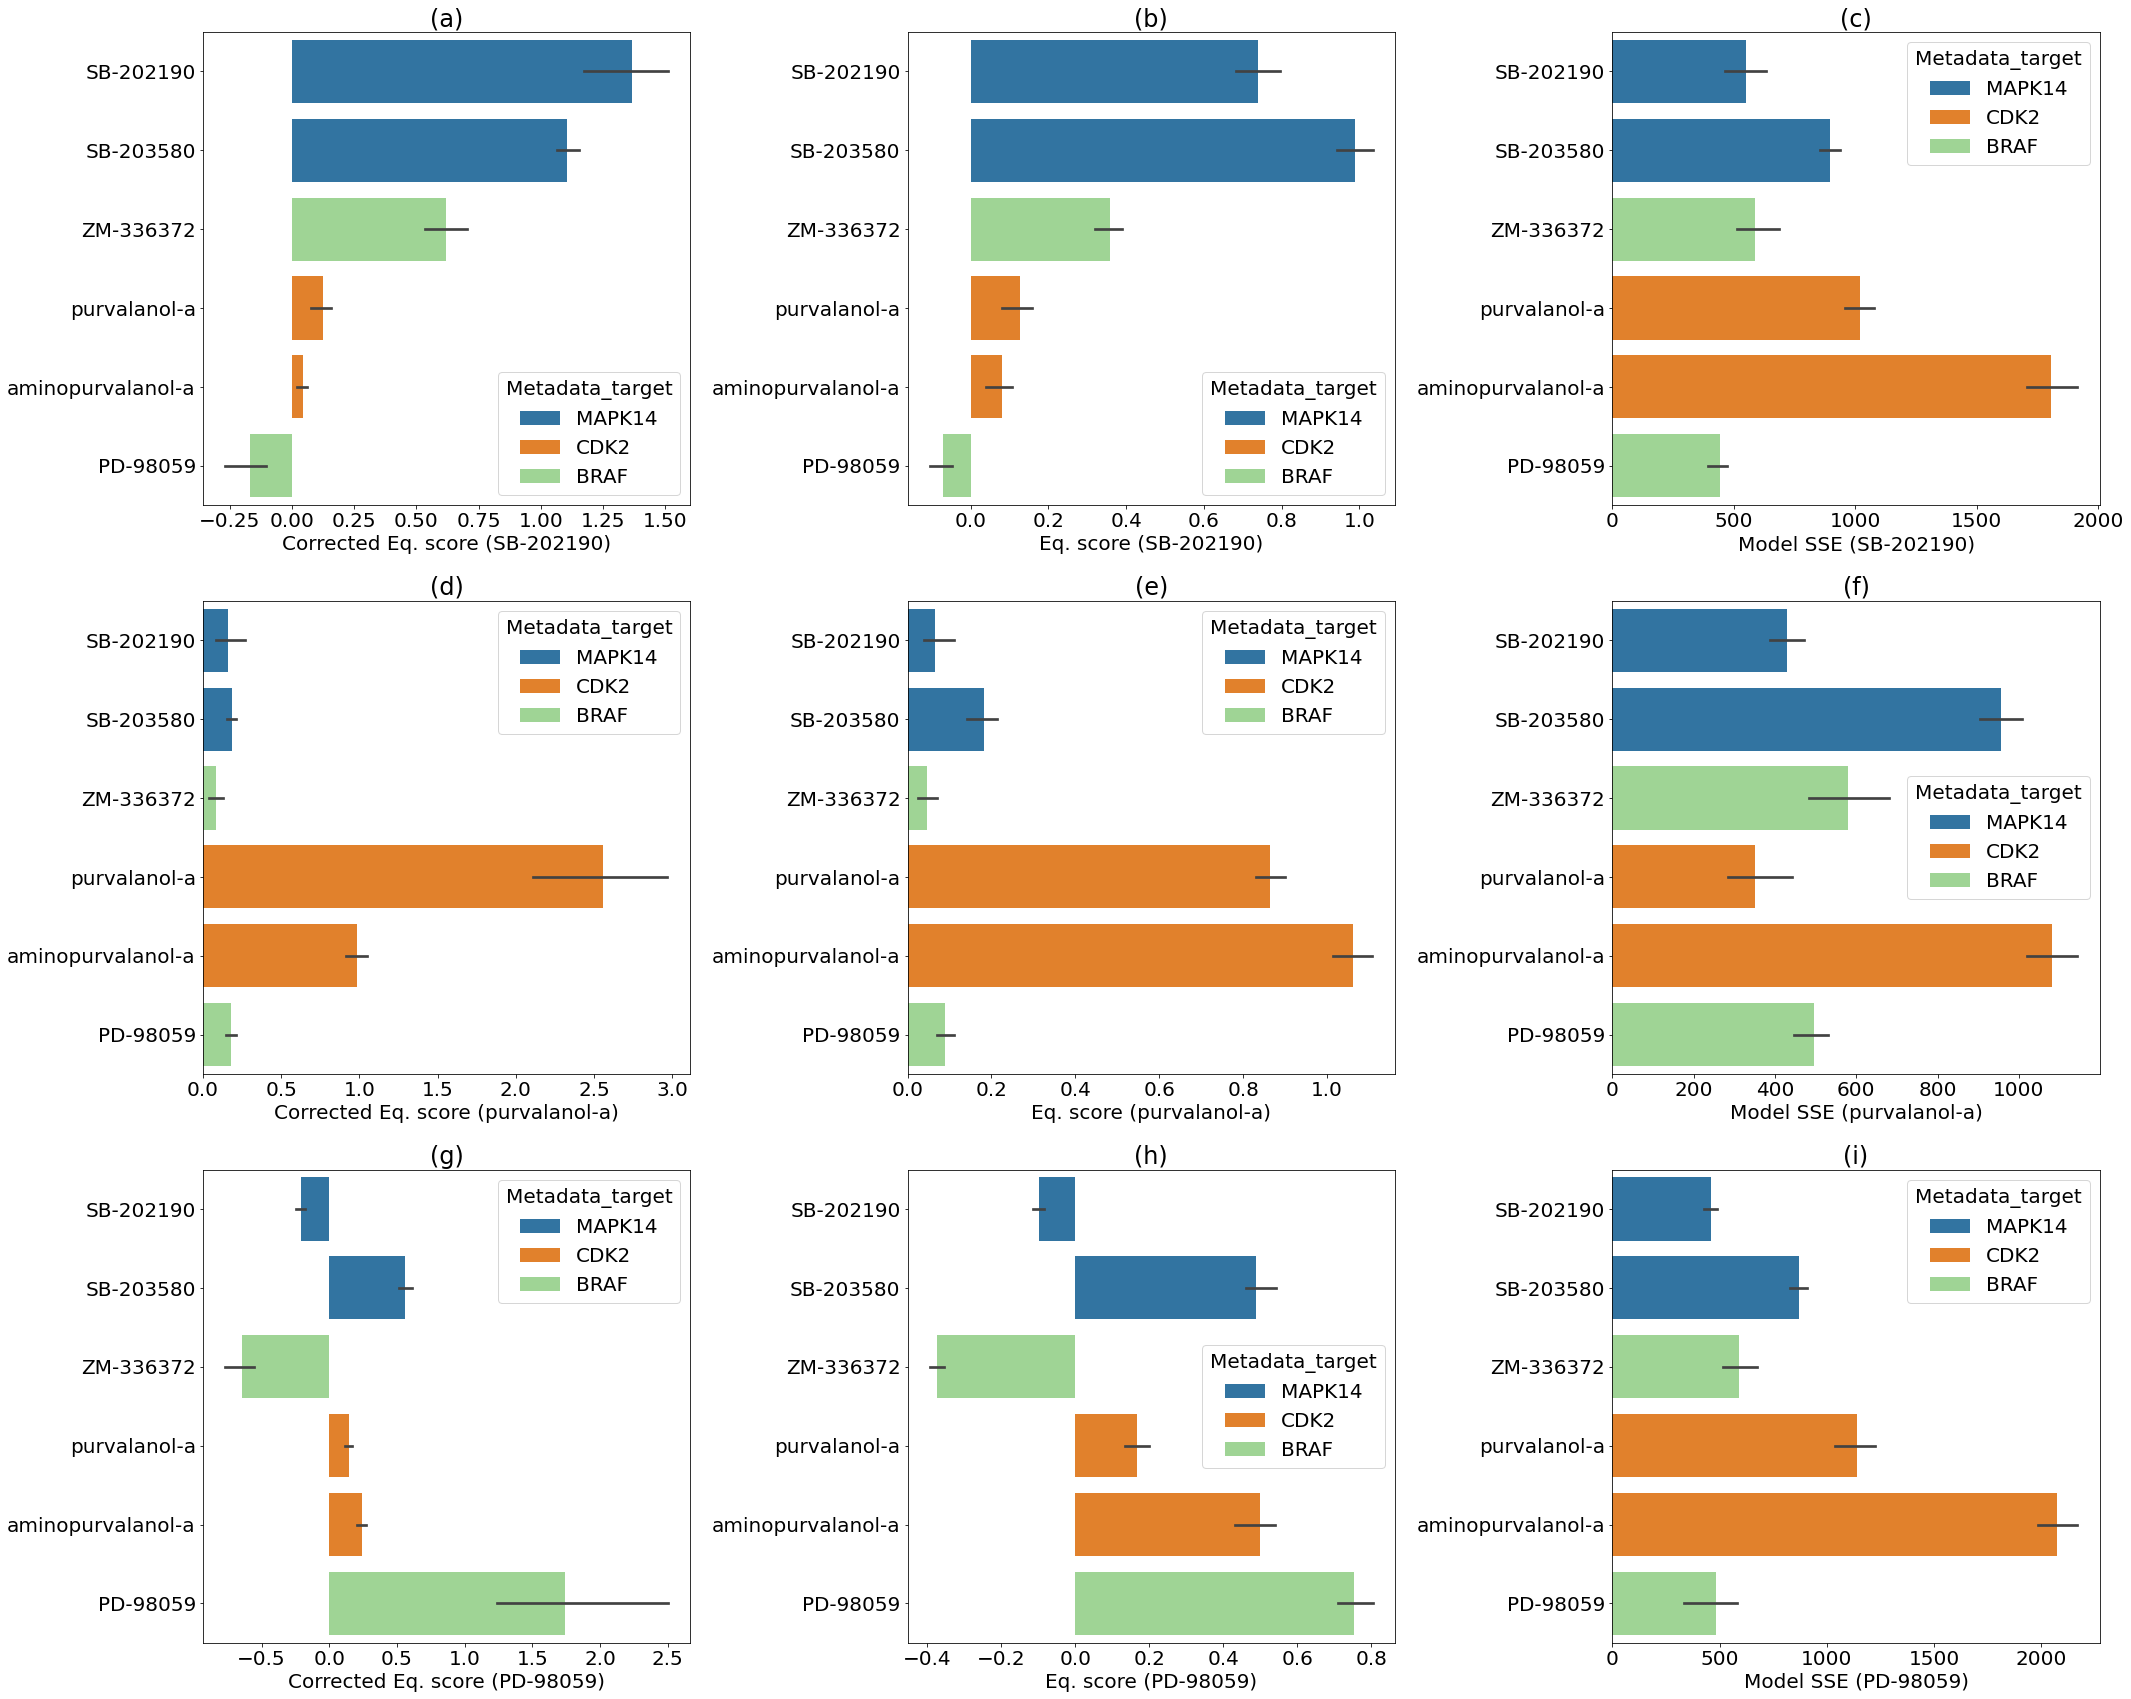

In [7]:
#### Generate Figure 5
from cycler import cycler
import matplotlib as mpl
rcParams['figure.figsize'] = 30, 24
rcParams['font.size'] = 20
cm = plt.get_cmap('tab20')
n_colors = len(opn_comp_eq_results['Metadata_pert_iname'].unique())
mpl.rcParams['axes.prop_cycle'] = cycler(color=[cm(1.*i/n_colors) for i in range(n_colors)])
n_compare=10
op_comp_eq_results = opn_comp_eq_results[opn_comp_eq_results['Metadata_pert_iname'] != 'DMSO'].copy()
abc = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
perts = ['SB-202190', 'purvalanol-a', 'PD-98059']
i = 0
j = 0
k = 0
fig, ax = plt.subplots(3,3)
for pert in perts:
    if pert == 'DMSO':
        pass        
    else:
        i = 0
        ind = []
        ind.append(pert)
        ind.extend(op_comp_eq_results.groupby('Metadata_pert_iname').aggregate(np.median).nlargest(n_compare, f"{pert}_eq").index.tolist())
        cond = (" | ".join(["(Metadata_pert_iname == '{0}')".format(i) for i in ind]))
        result = div_df.query(cond).groupby('Metadata_pert_iname')[f"{pert}_eq"].aggregate(np.median).reset_index().sort_values(f"{pert}_eq", ascending=False)        
        if j == 0:
                bar = sns.barplot(x=f"{pert}_eq", y='Metadata_pert_iname', data=div_df.query(cond), ax=ax[j, i], 
                     order=result['Metadata_pert_iname'], hue='Metadata_target', dodge=False)
                ordered_result = result.copy()
        else:
                bar = sns.barplot(x=f"{pert}_eq", y='Metadata_pert_iname', data=div_df.query(cond), ax=ax[j, i], 
                     order=ordered_result['Metadata_pert_iname'], hue='Metadata_target', dodge=False)
       
       
        ax[j, i].set_ylabel('')
        ax[j, i].set_xlabel(f"Corrected Eq. score ({pert})")
        ax[j, i].title.set_text(f"({abc[k]})")
        k += 1
        i += 1
        
        bar = sns.barplot(x=f"{pert}_eq", y='Metadata_pert_iname', data=op_comp_eq_results.query(cond), ax=ax[j, i], 
                     order=ordered_result['Metadata_pert_iname'], hue='Metadata_target', dodge=False)
      
        ax[j, i].set_xlabel(f"Eq. score ({pert})")
        ax[j, i].set_ylabel('')
        ax[j, i].title.set_text(f"({abc[k]})")
        k += 1
        i += 1
        bar = sns.barplot(x=f"{pert}_SSE", y='Metadata_pert_iname', data=opn_ess_df.query(cond), ax=ax[j, i], 
                    order=ordered_result['Metadata_pert_iname'], hue='Metadata_target', dodge=False)
        ax[j, i].set_xlabel(f"Model SSE ({pert})")
        ax[j, i].set_ylabel('')
        ax[j, i].title.set_text(f"({abc[k]})")
        k += 1
        fig.tight_layout()
        j += 1
# fig.savefig("/home/edfo/cpjump1/jump_analysis/manuscript_v2/figures/eq_bar_plot.png")

Summary of input table
----------------------
Observations: 280
Variables: 6
Missing values: 0 (0.0%)

Summary of PCA:
---------------
Number of components: 3
Total Variance explained: 97.5%
Variance explained by component:
    - Component 1 : 49.6%
    - Component 2 : 32.7%
    - Component 3 : 15.2%


<AxesSubplot:xlabel='T1', ylabel='T2'>

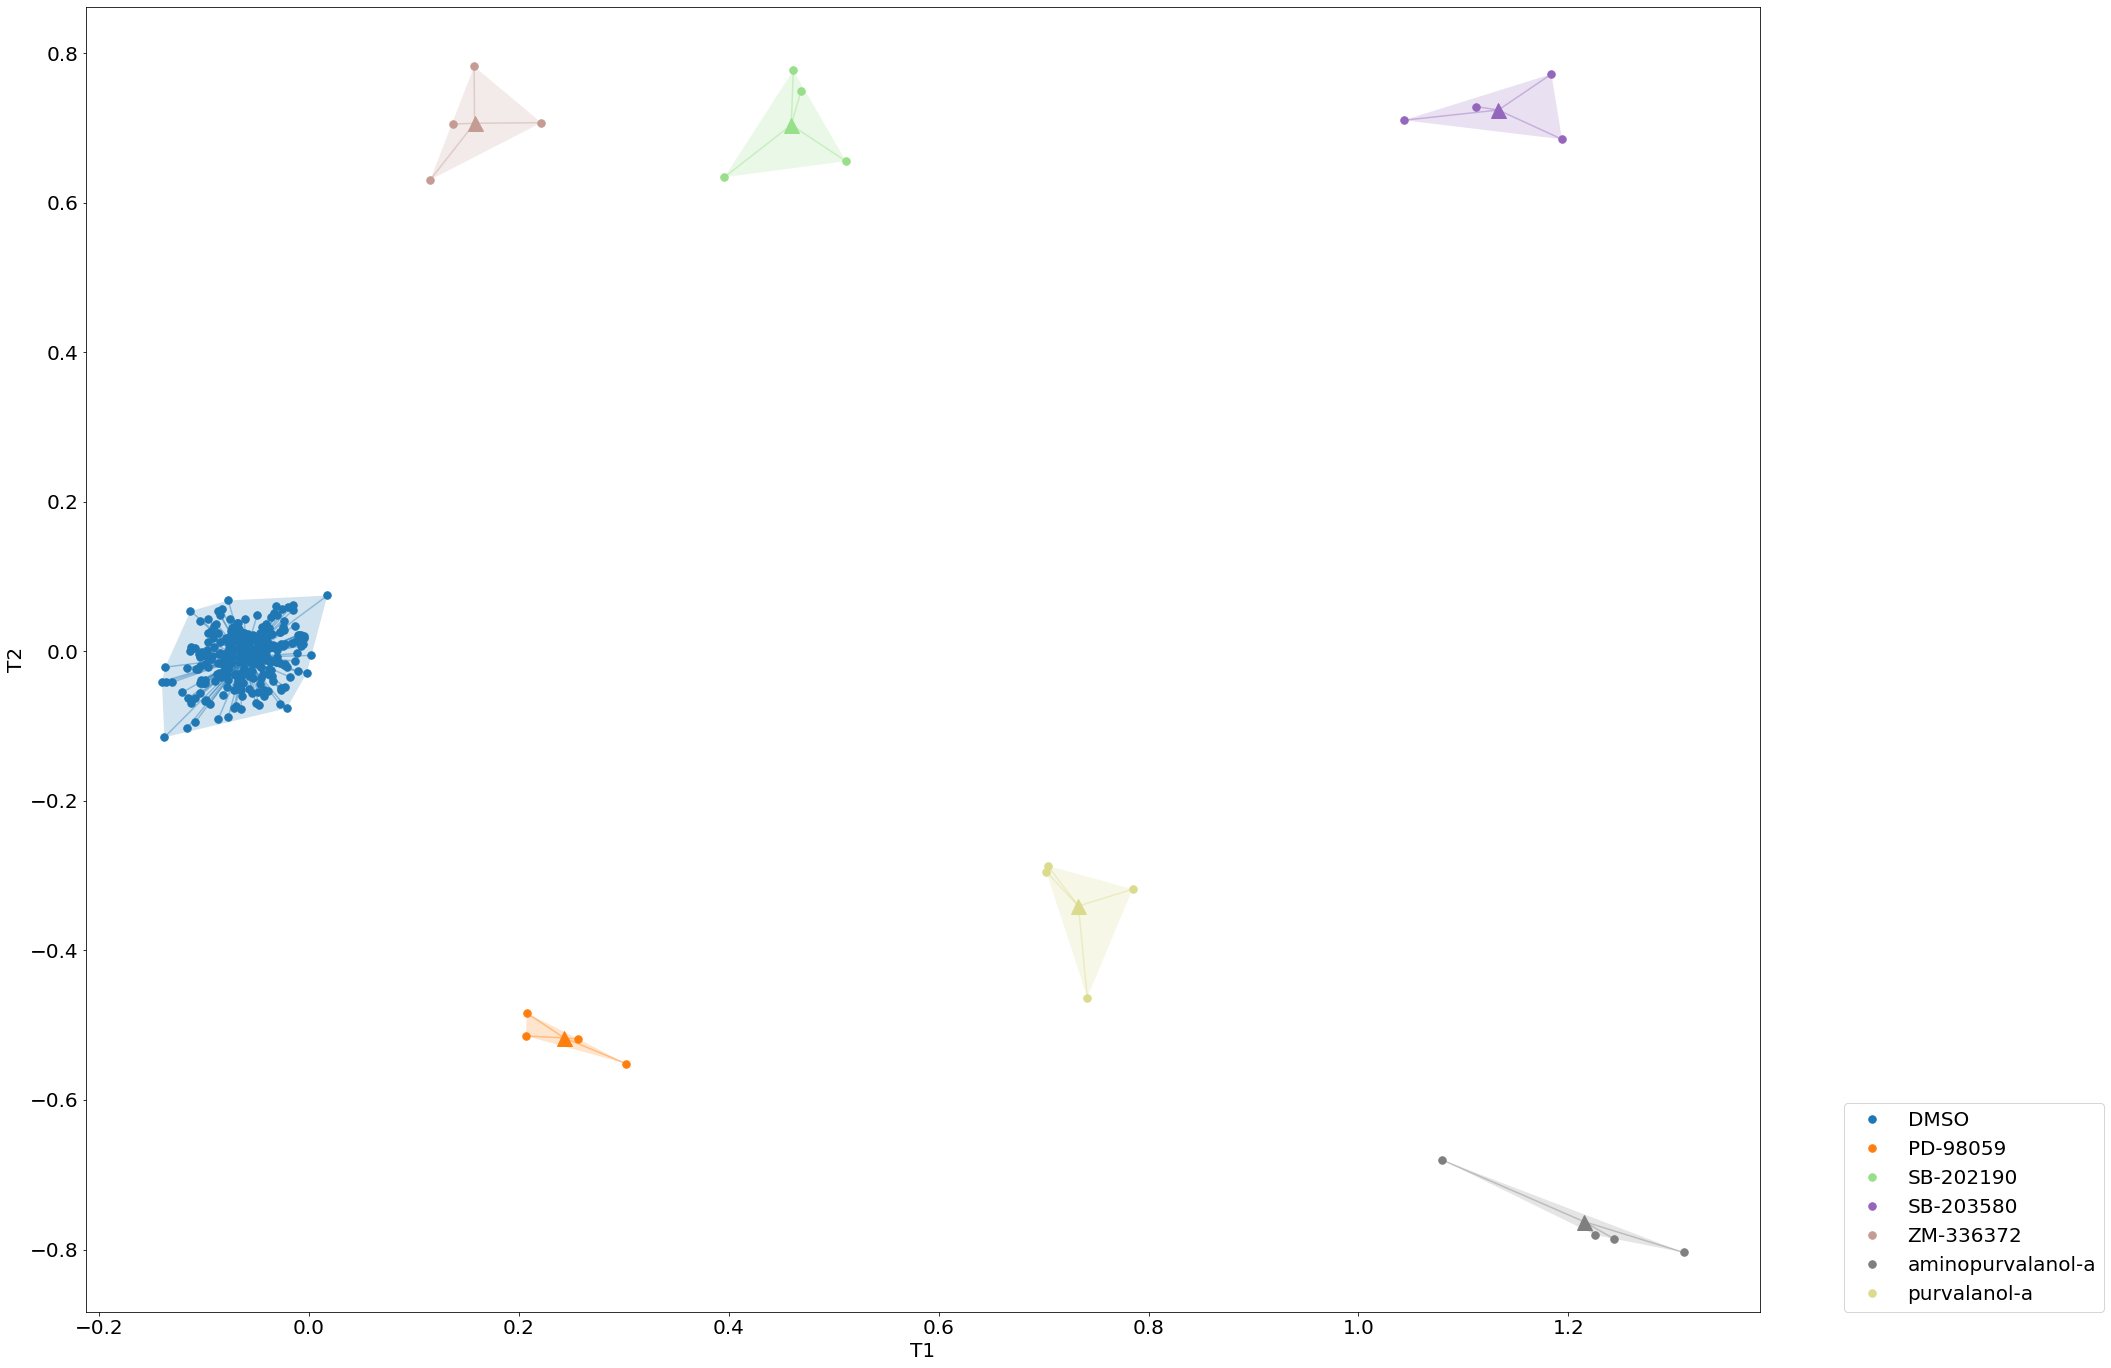

In [8]:
#### Generate Figure 6
pn_eq_results = opn_comp_eq_results.copy()
scaling = 0
pypls_pca = pyPLS.pca(ut.get_featuredata(pn_eq_results).values.astype(float), a=3, scaling=scaling)
pypls_pca.summary()

pn_eq_results['T1'] = pypls_pca.T[:, 0]
pn_eq_results['T2'] = pypls_pca.T[:, 1]
pn_eq_results['T3'] = pypls_pca.T[:, 2]
cp.plot_fig_with_clusters(pn_eq_results, metadata_grouping='Metadata_pert_iname', x_axis='T1', y_axis='T2', markersize=15)